# Distance Analysis Prototyping

Notebook for prototyping.

In [1]:
import sys
import pathlib
from itertools import product, tee
from dataclasses import dataclass
from typing import Tuple, List, Optional
import math

In [2]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib as mpl
import networkx as nx
import numpy as np
import momepy
from shapely import geometry, ops
from shapely.geometry import LineString
from tqdm.auto import tqdm

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
sys.path.append("..")

In [5]:
from src.preprocess import transform_df_to_trajectory_gdf
from src.visualize import random_colors

In [6]:
mpl.rcParams["figure.facecolor"] = "w"

# Read traffic lanes

Read traffic lanes as geopandas dataframe

In [7]:
trafficlanes_shapefile = pathlib.Path("../data/raw/rdb1/map_rdb1/shapefiles_trafficlanes")
trafficlanes = gpd.read_file(trafficlanes_shapefile)

In [8]:
trafficlanes.head()

,identifier,type,successors,geometry
0,308840,NORMAL,None,"LINESTRING (619275.680 5809210.783, 619270.841..."
1,308827,NORMAL,"1382090,1382091","LINESTRING (619267.575 5809220.289, 619272.474..."
2,307911,NORMAL,"1381550,1381551","LINESTRING (619301.721 5809211.188, 619289.351..."
3,307900,NORMAL,None,"LINESTRING (619290.881 5809202.915, 619303.266..."
4,1381551,NORMAL,307861,"LINESTRING (619289.351 5809205.791, 619286.761..."


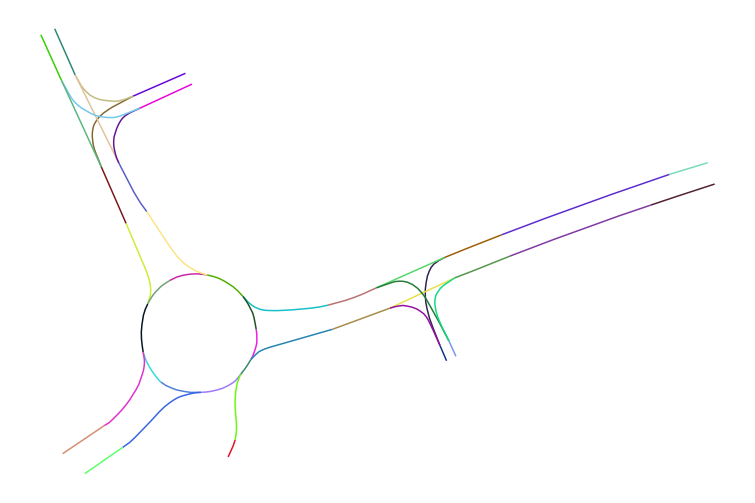

In [9]:
fig, ax = plt.subplots(figsize=(16, 9))
trafficlanes.plot(ax=ax, color=random_colors(len(trafficlanes)), label="traffic lanes")
ax.set_axis_off()
# fig.suptitle("traffic lanes $rdb_1$")

In [10]:
del trafficlanes["successors"]

Read traffic lanes as a `networkx.classes.digraph.DiGraph`

In [11]:
traffic_lanes_graph = momepy.gdf_to_nx(trafficlanes, approach='primal', directed=True, multigraph=False)

In [12]:
traffic_lanes_graph

# Generate possible paths

In [13]:
from src.path_extraction import DrivablePath, graph_path_to_linestring, extract_paths_from_graph, driving_path_overview_plot

Find nodes with only one incoming and outgoing edge

In [14]:
start_nodes = [node for node, degree in traffic_lanes_graph.in_degree if degree == 0]
end_nodes = [node for node, degree in traffic_lanes_graph.out_degree if degree == 0]

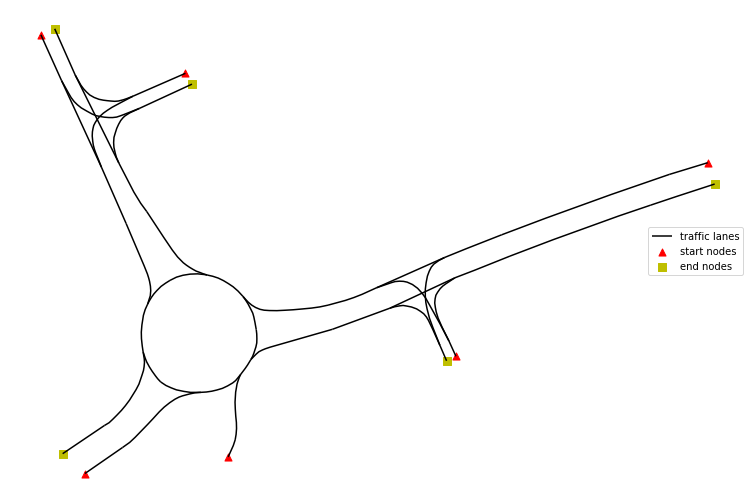

In [15]:
fig, ax = plt.subplots(figsize=(16, 9))
trafficlanes.plot(ax=ax, color="k", label="traffic lanes")

start_nodes_matrix = np.array(start_nodes)
ax.scatter(start_nodes_matrix[:, 0], start_nodes_matrix[:, 1], s=50, color="r", marker="^", label="start nodes")

end_nodes_matrix = np.array(end_nodes)
ax.scatter(end_nodes_matrix[:, 0], end_nodes_matrix[:, 1], s=50, color="y", marker="s", label="end nodes")

ax.legend(loc=5)
ax.set_axis_off()

Find all possible paths between the combination of start- and end nodes

In [16]:
paths = extract_paths_from_graph(traffic_lanes_graph)

In [17]:
num_paths = len(paths)

In [18]:
print(num_paths, "paths found!")

30 paths found!


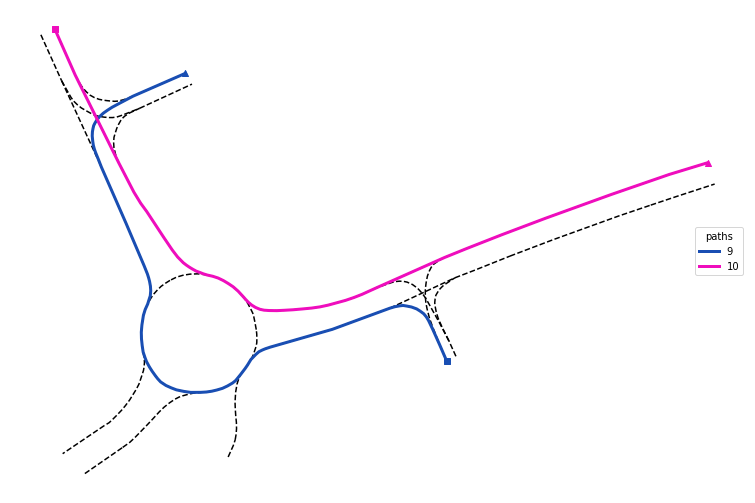

In [19]:
fig, ax = plt.subplots(figsize=(16, 9))
trafficlanes.plot(ax=ax, color="k", linestyle="--")

N = 2
colors = random_colors(N, seed=43)

for i, dp in enumerate(paths[9:9+N]):
    dp.plot(ax, color=colors[i])

ax.legend(title="paths", loc=5)
ax.set_axis_off()

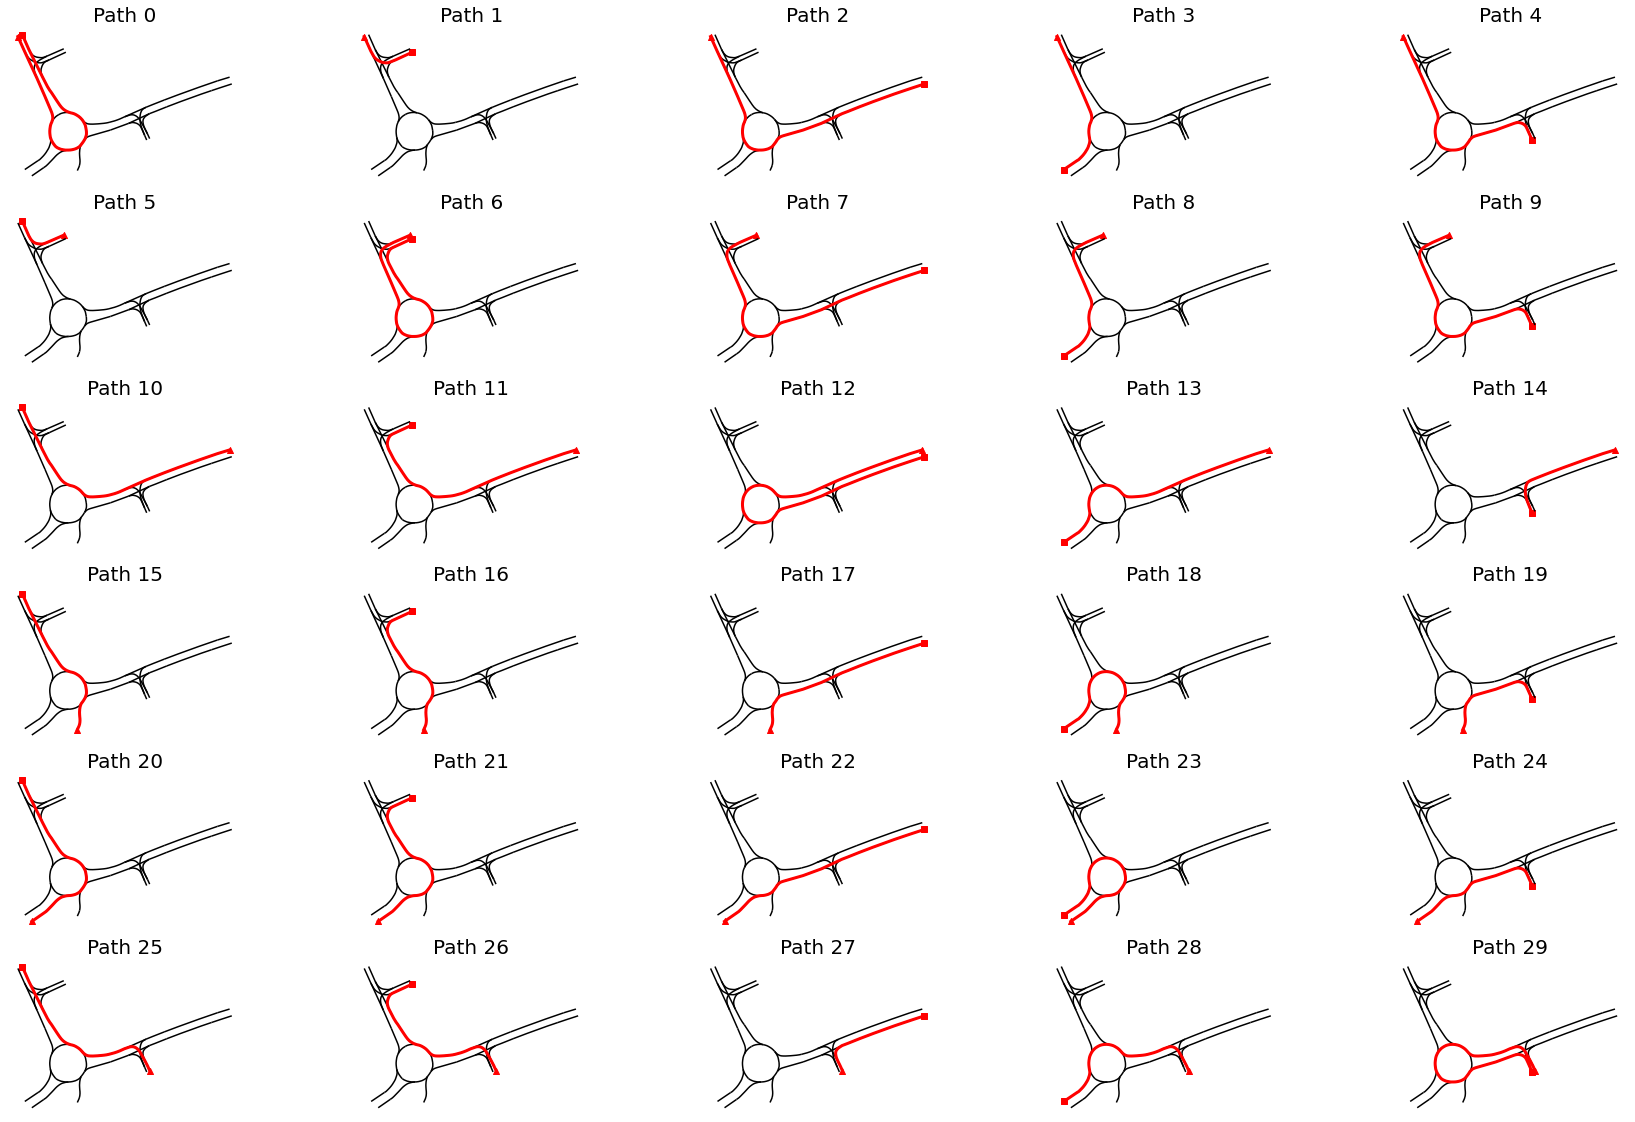

In [22]:
fig = driving_path_overview_plot(trafficlanes, paths)

for ax in fig.axes:
    ax.title.set_fontsize(20)

# Read vehicle trajectory data

## Trajectory class

In [21]:
from src.trajectory import Trajectory

In [22]:
from src.opendd import VEHICLE_CLASSES
from src.preprocess import transform_df_to_trajectory_gdf

In [23]:
data_path = "../data/raw/rdb1.parquet"

In [24]:
VEHICLE_SAMPLE_RATE = 30.0

In [25]:
df = pd.read_parquet(data_path)

In [26]:
df.sample(10)

,index,ID,TIMESTAMP,OBJID,UTM_X,UTM_Y,UTM_ANGLE,V,ACC,ACC_LAT,ACC_TAN,CLASS,WIDTH,LENGTH,table
3228174,171558,171559,548.114233,4737,619335.26,5809156.03,3.413785,0.45,1.0019,0.0603,-1.0000,Car,1.9609,4.3741,rdb1_18
6407020,8945,8946,14.647967,9810,619337.98,5809142.99,0.414685,3.55,0.2774,0.2434,-0.1331,Bicycle,0.7696,1.5442,rdb1_37
17978677,23044,23045,101.901800,31004,619301.28,5809160.51,3.322385,6.35,3.2901,-3.2877,0.1270,Car,2.0675,4.8722,rdb1_147
17972527,16894,16895,62.796067,30991,619287.22,5809177.45,5.119185,3.65,0.1477,0.0015,0.1477,Car,1.8000,4.3194,rdb1_147
4625929,53901,53902,196.496300,7232,619291.08,5809144.09,4.582785,6.37,0.9067,0.8369,0.3489,Car,1.7755,4.3415,rdb1_29
3503088,35066,35067,176.409567,5293,619285.04,5809121.33,0.632885,6.83,0.2121,-0.2121,0.0014,Car,1.9700,4.3990,rdb1_21
10143595,51763,51764,233.933700,16501,619301.43,5809137.51,5.884685,5.77,2.6741,-2.6740,0.0161,Car,1.7986,3.6808,rdb1_69
14932890,127730,127731,362.228533,25284,619287.36,5809134.01,4.207985,5.75,1.1715,0.7771,0.8767,Medium Vehicle,2.0616,5.4922,rdb1_118
14194386,116277,116278,439.672567,24032,619309.06,5809160.84,2.616885,8.79,2.3162,2.1395,0.8874,Car,1.8235,3.8022,rdb1_112
14172207,94098,94099,349.716033,23984,619295.73,5809130.11,0.685785,0.00,0.0026,-0.0001,0.0026,Car,2.0000,4.4934,rdb1_112


In [27]:
df["k"] = (df["TIMESTAMP"] * VEHICLE_SAMPLE_RATE).round().astype(int)

In [28]:
df.head()

,index,ID,TIMESTAMP,OBJID,UTM_X,UTM_Y,UTM_ANGLE,V,ACC,ACC_LAT,ACC_TAN,CLASS,WIDTH,LENGTH,table,k
0,0,1,0.000000,1,619302.33,5809133.78,0.453485,4.74,0.1415,-0.1201,0.0747,Heavy Vehicle,2.7892,6.0217,rdb1_1,0
1,1,2,0.033367,1,619302.47,5809133.85,0.452985,4.75,0.1341,-0.1156,0.0679,Heavy Vehicle,2.7892,6.0217,rdb1_1,1
2,2,3,0.066733,1,619302.61,5809133.91,0.452485,4.75,0.1316,-0.1063,0.0776,Heavy Vehicle,2.7892,6.0217,rdb1_1,2
3,3,4,0.100100,1,619302.76,5809133.98,0.451985,4.75,0.1368,-0.0920,0.1013,Heavy Vehicle,2.7892,6.0217,rdb1_1,3
4,4,5,0.133467,1,619302.90,5809134.05,0.451485,4.76,0.1568,-0.0729,0.1388,Heavy Vehicle,2.7892,6.0217,rdb1_1,4


In [29]:
df = df[df["table"] == "rdb1_1"]

In [30]:
df.sample(10)

,index,ID,TIMESTAMP,OBJID,UTM_X,UTM_Y,UTM_ANGLE,V,ACC,ACC_LAT,ACC_TAN,CLASS,WIDTH,LENGTH,table,k
156183,156183,156184,410.243167,249,619319.14,5809156.44,2.817585,6.16,1.0512,0.8103,0.6696,Car,1.8321,4.5569,rdb1_1,12307
117589,117589,117590,340.606933,202,619325.92,5809154.85,3.163285,4.21,0.9806,0.9770,0.0834,Car,2.0877,4.9795,rdb1_1,10218
97785,97785,97786,286.953333,171,619286.88,5809178.58,5.143885,4.22,0.2469,-0.0237,0.2458,Car,1.7876,4.4690,rdb1_1,8609
57798,57798,57799,175.508667,104,619326.07,5809154.05,3.236885,0.12,0.3764,-0.1821,0.3295,Car,1.9481,4.7139,rdb1_1,5265
14836,14836,14837,27.360667,27,619289.85,5809170.99,5.130385,3.79,0.4694,0.1738,-0.4360,Car,1.7952,3.5889,rdb1_1,821
108407,108407,108408,320.553567,191,619308.54,5809137.36,0.474785,8.56,1.5454,0.0540,1.5444,Car,1.9401,4.6140,rdb1_1,9617
61826,61826,61827,195.795600,109,619293.37,5809151.71,4.313185,6.04,1.6333,-1.6278,0.1344,Car,1.8209,4.8798,rdb1_1,5874
150475,150475,150476,425.725300,242,619270.91,5809120.06,3.721485,5.05,1.2063,0.1581,1.1959,Car,1.8538,4.3286,rdb1_1,12772
5259,5259,5260,3.403400,13,619288.22,5809124.13,0.673985,5.91,0.1597,-0.1597,0.0003,Car,1.9974,4.4595,rdb1_1,102
100956,100956,100957,301.801500,177,619332.37,5809155.91,3.431585,3.04,0.4294,0.4287,-0.0249,Motorcycle,1.0370,2.2946,rdb1_1,9054


In [31]:
gdf_traces = transform_df_to_trajectory_gdf(df)

In [32]:
gdf_traces["START_TIME_DISCRETE"] = (gdf_traces["START_TIME"] * VEHICLE_SAMPLE_RATE).round().astype(int)

Transform data frame from samples to trajectories (timeseries)

In [33]:
# keep only motorized vehicles
gdf_traces = gdf_traces[gdf_traces["CLASS"].isin(VEHICLE_CLASSES)]

In [34]:
gdf_traces.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 332 entries, 1 to 356
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   CLASS                332 non-null    object  
 1   WIDTH                332 non-null    float64 
 2   LENGTH               332 non-null    float64 
 3   START_TIME           332 non-null    float64 
 4   NUM_SAMPLES          332 non-null    int64   
 5   V                    332 non-null    object  
 6   ACC                  332 non-null    object  
 7   geometry             332 non-null    geometry
 8   START_TIME_DISCRETE  332 non-null    int32   
dtypes: float64(3), geometry(1), int32(1), int64(1), object(3)
memory usage: 24.6+ KB


In [35]:
gdf_traces.head()

,CLASS,WIDTH,LENGTH,START_TIME,NUM_SAMPLES,V,ACC,geometry,START_TIME_DISCRETE
OBJID,,,,,,,,,
1,Heavy Vehicle,2.7892,6.0217,0.0,341,"[4.74, 4.75, 4.75, 4.75, 4.76, 4.76, 4.77, 4.7...","[0.1415, 0.1341, 0.1316, 0.1368, 0.1568, 0.254...","LINESTRING (619302.330 5809133.780, 619302.470...",0
2,Car,1.7950,4.3806,0.0,556,"[0.33, 0.34, 0.34, 0.35, 0.36, 0.37, 0.39, 0.4...","[0.1092, 0.1466, 0.1976, 0.285, 0.4123, 0.5232...","LINESTRING (619286.670 5809178.010, 619286.680...",0
3,Car,1.8667,3.7854,0.0,241,"[1.32, 1.32, 1.32, 1.32, 1.32, 1.31, 1.31, 1.3...","[0.0693, 0.0556, 0.0376, 0.0246, 0.0954, 0.177...","LINESTRING (619281.510 5809126.720, 619281.470...",0
4,Car,1.7642,4.4819,0.0,286,"[3.78, 3.75, 3.72, 3.68, 3.64, 3.6, 3.56, 3.52...","[0.9199, 1.0231, 1.1121, 1.1865, 1.2474, 1.308...","LINESTRING (619288.840 5809134.990, 619288.780...",0
5,Medium Vehicle,2.1041,4.8186,0.0,216,"[4.6, 4.63, 4.66, 4.69, 4.72, 4.75, 4.78, 4.82...","[1.3951, 1.5709, 1.7314, 1.8746, 2.0001, 2.119...","LINESTRING (619316.990 5809146.380, 619317.010...",0


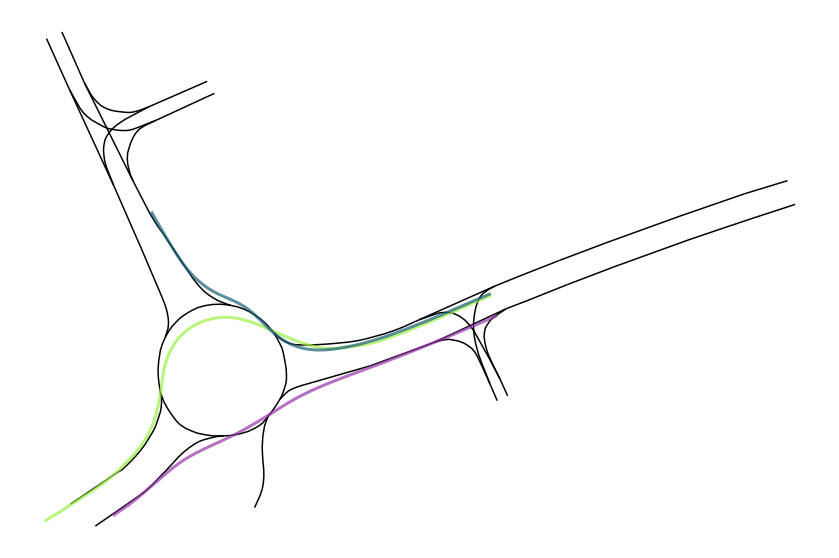

In [36]:
N = 3

fig, ax = plt.subplots(figsize=(15, 10))
trafficlanes.plot(ax=ax, color="k")

colors = random_colors(N, seed=115)
gdf_traces.sample(N, random_state=115).plot(ax=ax, alpha=0.7, lw=3, color=colors)

# cx.add_basemap(ax, crs=gdf_traces_vehicle.crs.to_string(), source=cx.providers.CartoDB.Voyager, zoom="auto")
ax.set_axis_off()

## Add driving states

In [37]:
from src.preprocess import VehicleState, identify_driving_state

In [38]:
identify_driving_state?

In [39]:
gdf_traces["STATE"] = gdf_traces.apply(lambda row: identify_driving_state(row), axis=1)

In [40]:
len(gdf_traces)

332

In [41]:
vp1 = gdf_traces.iloc[101]
vp2 = gdf_traces.iloc[104]
traj1 = Trajectory.from_trace(vp1, ["V", "ACC", "STATE"])
traj2 = Trajectory.from_trace(vp2, ["V", "ACC", "STATE"])

Text(0.5, 0, 'time [s]')

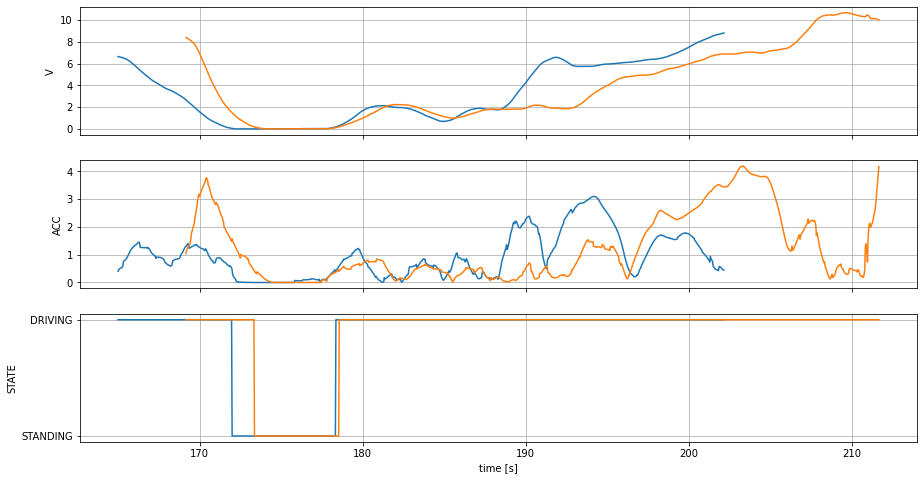

In [42]:
fig, axs = plt.subplots(nrows=traj1.dim, figsize=(15, 8), sharex=True)

for i, ax in enumerate(axs):
    ax.set_ylabel(traj1.names[i])
    ax.grid()

traj1.plot(axs)
traj2.plot(axs)

axs[-1].set_yticks([VehicleState.STANDING.value, VehicleState.DRIVING.value])
axs[-1].set_yticklabels([VehicleState.STANDING.name, VehicleState.DRIVING.name])




axs[-1].set_xlabel("time [s]")

In [43]:
str(VehicleState.DRIVING.name)

'DRIVING'

# Assign trajectory data to paths

## Single vehicle example

In [44]:
vehicle_path = gdf_traces.iloc[1]

In [45]:
vehicle_path

CLASS                                                                Car
WIDTH                                                              1.795
LENGTH                                                            4.3806
START_TIME                                                           0.0
NUM_SAMPLES                                                          556
V                      [0.33, 0.34, 0.34, 0.35, 0.36, 0.37, 0.39, 0.4...
ACC                    [0.1092, 0.1466, 0.1976, 0.285, 0.4123, 0.5232...
geometry               LINESTRING (619286.67 5809178.01, 619286.68000...
START_TIME_DISCRETE                                                    0
STATE                  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...
Name: 2, dtype: object

In [46]:
vehicle_path_linestring = vehicle_path.geometry

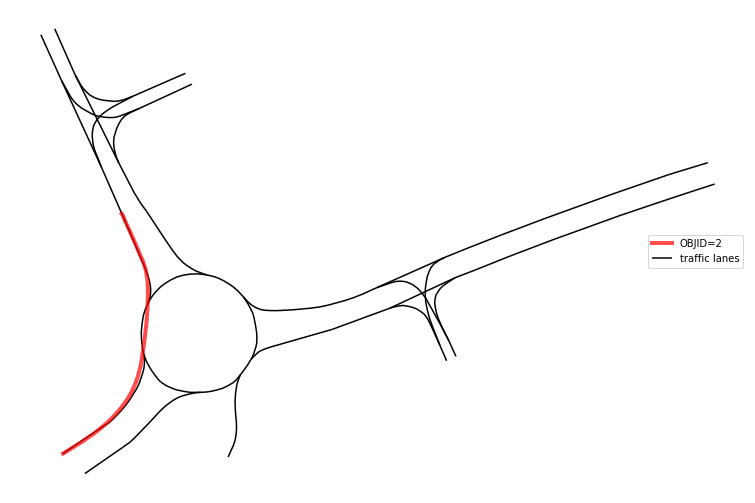

In [47]:
fig, ax = plt.subplots(figsize=(16, 9))
trafficlanes.plot(ax=ax, color="k", label="traffic lanes")
ax.plot(*vehicle_path_linestring.xy, lw=4, c="red", alpha=0.7, label=f"OBJID={vehicle_path.name}")
ax.set_axis_off()
ax.legend(loc=5)

In [48]:
from src.path_assignment import compute_path_distance

In [49]:
distances = list()

N = 100

for i, dp in enumerate(paths):
    
    d = compute_path_distance(vehicle_path_linestring, dp.path, N)
    distances.append(d)

distances = np.array(distances)

In [50]:
distances

array([28.49061682, 80.06795936, 28.49061682,  5.75742858, 28.49061682,
       84.02277521, 28.49061682, 28.49061682,  5.75742858, 28.49061682,
       53.18809294, 53.18809294, 28.49061682, 19.39490101, 92.26269721,
       38.99208628, 38.99208628, 45.91473764, 19.39490101, 45.91473764,
       17.86996647, 17.86996647, 45.35059148, 19.39490101, 45.35059148,
       53.18809294, 53.18809294, 94.18546821, 19.39490101, 28.49061682])

In [51]:
print(distances.argmin())

3


In [52]:
distances

array([28.49061682, 80.06795936, 28.49061682,  5.75742858, 28.49061682,
       84.02277521, 28.49061682, 28.49061682,  5.75742858, 28.49061682,
       53.18809294, 53.18809294, 28.49061682, 19.39490101, 92.26269721,
       38.99208628, 38.99208628, 45.91473764, 19.39490101, 45.91473764,
       17.86996647, 17.86996647, 45.35059148, 19.39490101, 45.35059148,
       53.18809294, 53.18809294, 94.18546821, 19.39490101, 28.49061682])

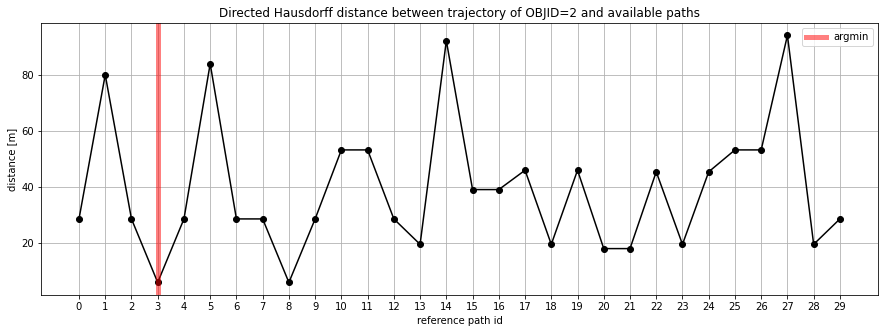

In [53]:
plt.figure(figsize=(15, 5))
plt.plot(distances, "ko-")
plt.axvline(distances.argmin(), color="r", label="argmin", lw=5, alpha=0.5)
plt.grid()
plt.xlabel("reference path id")
plt.ylabel("distance [m]")
plt.xticks(np.arange(len(paths)), np.arange(len(paths)));
plt.title(f"Directed Hausdorff distance between trajectory of OBJID={vehicle_path.name} and available paths")
plt.legend()

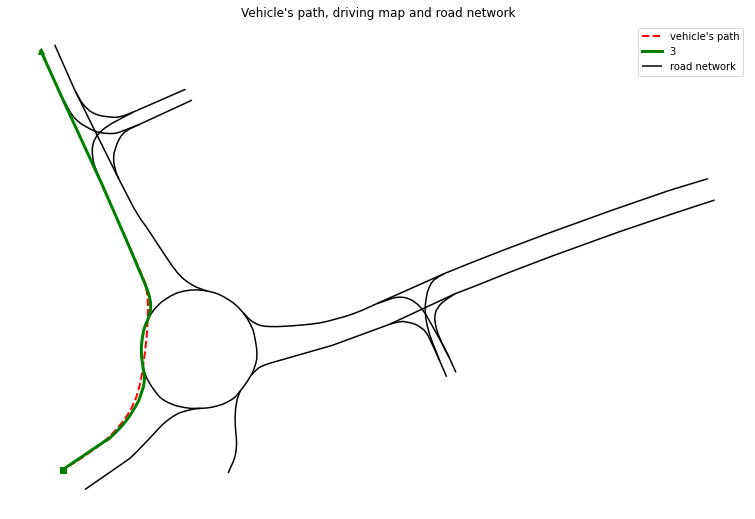

In [54]:
fig, ax = plt.subplots(figsize=(16, 9))
trafficlanes.plot(ax=ax, color="k", label="road network")
ax.plot(*vehicle_path_linestring.xy, lw=2, c="red", ls="--", label="vehicle's path")
paths[distances.argmin()].plot(ax, color="green")
ax.set_axis_off()
ax.set_title("Vehicle's path, driving map and road network")
ax.legend()

## Multiple vehicles

In [55]:
from src.path_assignment import find_nearest_path

In [56]:
tqdm.pandas()

In [57]:
gdf_traces["path_id"] = gdf_traces.progress_apply(lambda row: find_nearest_path(row["geometry"], paths, N=20), axis=1)

  0%|          | 0/332 [00:00<?, ?it/s]

In [58]:
gdf_traces.head()

,CLASS,WIDTH,LENGTH,START_TIME,NUM_SAMPLES,V,ACC,geometry,START_TIME_DISCRETE,STATE,path_id
OBJID,,,,,,,,,,,
1,Heavy Vehicle,2.7892,6.0217,0.0,341,"[4.74, 4.75, 4.75, 4.75, 4.76, 4.76, 4.77, 4.7...","[0.1415, 0.1341, 0.1316, 0.1368, 0.1568, 0.254...","LINESTRING (619302.330 5809133.780, 619302.470...",0,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0
2,Car,1.7950,4.3806,0.0,556,"[0.33, 0.34, 0.34, 0.35, 0.36, 0.37, 0.39, 0.4...","[0.1092, 0.1466, 0.1976, 0.285, 0.4123, 0.5232...","LINESTRING (619286.670 5809178.010, 619286.680...",0,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",3
3,Car,1.8667,3.7854,0.0,241,"[1.32, 1.32, 1.32, 1.32, 1.32, 1.31, 1.31, 1.3...","[0.0693, 0.0556, 0.0376, 0.0246, 0.0954, 0.177...","LINESTRING (619281.510 5809126.720, 619281.470...",0,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",3
4,Car,1.7642,4.4819,0.0,286,"[3.78, 3.75, 3.72, 3.68, 3.64, 3.6, 3.56, 3.52...","[0.9199, 1.0231, 1.1121, 1.1865, 1.2474, 1.308...","LINESTRING (619288.840 5809134.990, 619288.780...",0,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",3
5,Medium Vehicle,2.1041,4.8186,0.0,216,"[4.6, 4.63, 4.66, 4.69, 4.72, 4.75, 4.78, 4.82...","[1.3951, 1.5709, 1.7314, 1.8746, 2.0001, 2.119...","LINESTRING (619316.990 5809146.380, 619317.010...",0,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0


In [59]:
gdf_traces["START_TIME"].iloc[:20]

OBJID
1      0.000000
2      0.000000
3      0.000000
4      0.000000
5      0.000000
6      0.000000
7      0.000000
8      0.000000
9      0.000000
11     0.000000
13     2.836167
14     4.504500
15     5.672333
16     6.840167
17     8.008000
18    10.176833
19    11.678333
20    14.347667
21    15.181833
24    17.350667
Name: START_TIME, dtype: float64

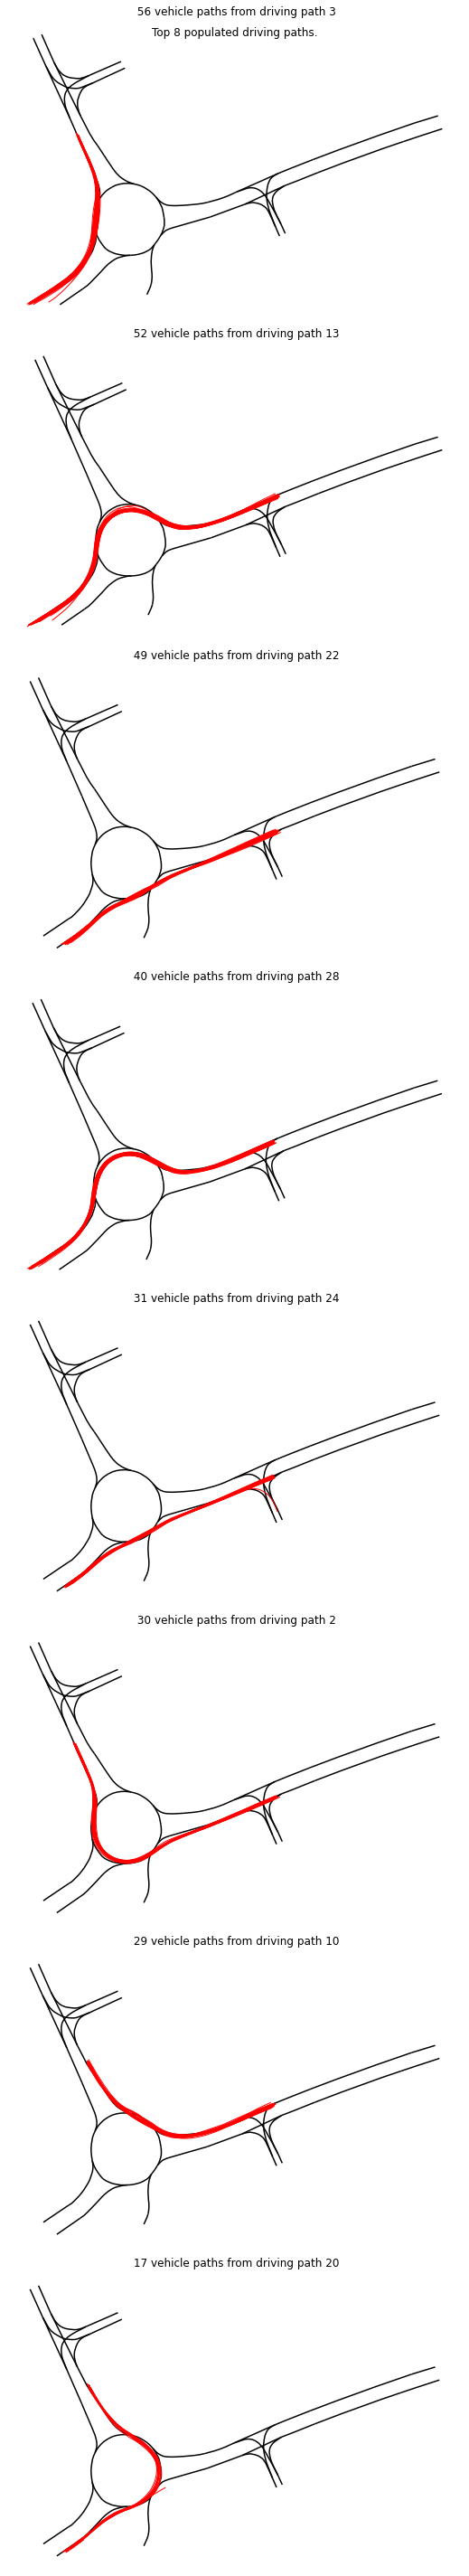

In [60]:
N = 8

fig, axs = plt.subplots(nrows=N, figsize=(10, 5*N))

toplist_path = gdf_traces["path_id"].value_counts()

for i, (path_id, cnt) in enumerate(toplist_path.iloc[:N].iteritems()):
    
    ax = axs[i]
    trafficlanes.plot(ax=ax, color="k", label="traffic lanes")
    
    vehicle_paths = gdf_traces[gdf_traces["path_id"]==path_id]
    
    for i, vp in vehicle_paths.iterrows():
        ax.plot(*vp.geometry.xy, lw=1, color="r")
    ax.set_axis_off()
    ax.set_title(f"{cnt: d} vehicle paths from driving path {path_id:d}")
    
fig.suptitle(f"Top {N} populated driving paths.")
plt.tight_layout()

# Project to Frenet Frame

Helpful link: https://fjp.at/posts/optimal-frenet/

## Example on single trajectory

In [61]:
from src.reference_path import DiscreteReferencePath

In [63]:
example_path = paths[13].as_linestring()
example_reference = DiscreteReferencePath.from_linestring(example_path, 0.1)

In [64]:
example_reference.length

187.40000000000015

In [65]:
example_trip = gdf_traces[gdf_traces["path_id"] == 13].iloc[10]
example_trip

CLASS                                                                Car
WIDTH                                                             1.9112
LENGTH                                                            4.2946
START_TIME                                                    272.438833
NUM_SAMPLES                                                          591
V                      [1.6, 1.6, 1.6, 1.61, 1.61, 1.62, 1.63, 1.64, ...
ACC                    [0.133, 0.0986, 0.0444, 0.0354, 0.1215, 0.1877...
geometry               LINESTRING (619362.96 5809167.38, 619362.91 58...
START_TIME_DISCRETE                                                 8173
STATE                  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...
path_id                                                               13
Name: 162, dtype: object

In [66]:
example_trip_frenet = example_reference.linestring_to_frenet(example_trip.geometry)

(-10.0, 10.0)

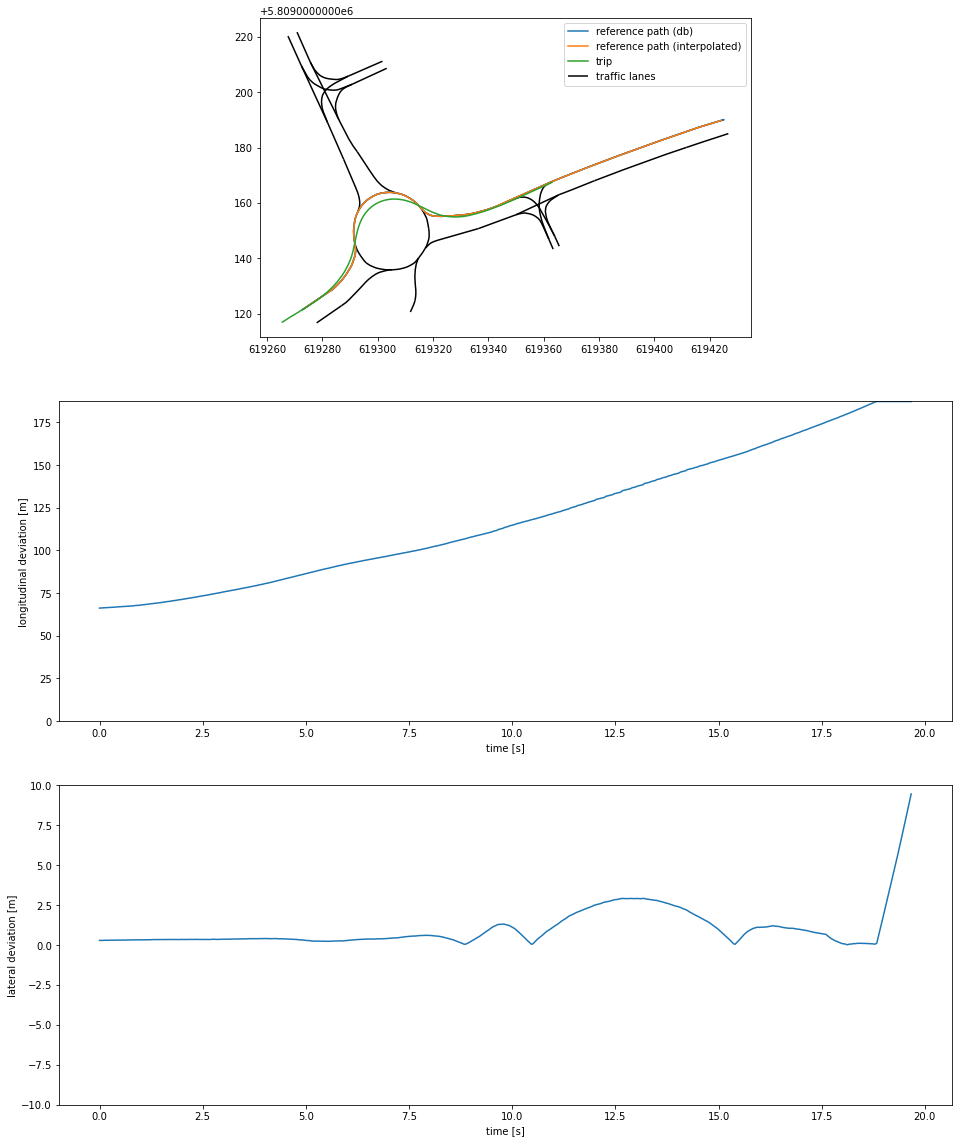

In [67]:
fig, (ax_cart, ax_frenet_lon, ax_frenet_lat) = plt.subplots(nrows=3, figsize=(16, 20))

trafficlanes.plot(ax=ax_cart, color="k", label="traffic lanes")
ax_cart.plot(*example_path.xy, label="reference path (db)")
ax_cart.plot(*example_reference.as_linestring().xy, label="reference path (interpolated)")
ax_cart.plot(*example_trip.geometry.xy, label="trip")
ax_cart.legend()

t_array = 1/30*np.arange(0, len(example_trip_frenet.xy[0]))
s_array, d_array = example_trip_frenet.xy
ax_frenet_lon.plot(t_array, s_array)
ax_frenet_lat.plot(t_array, d_array)

ax_frenet_lon.set_ylabel("longitudinal deviation [m]")
ax_frenet_lat.set_ylabel("lateral deviation [m]")

ax_frenet_lon.set_xlabel("time [s]")
ax_frenet_lat.set_xlabel("time [s]")


ax_frenet_lon.set_ylim([0, example_reference.length])
ax_frenet_lat.set_ylim([-10, 10])

## Project to frenet for all trajectories

In [68]:
reference_paths = [DiscreteReferencePath.from_linestring(dp.as_linestring(), resolution=0.05) for dp in paths]

In [69]:
def row_to_frenet(trace: pd.Series, reference_paths: List[DiscreteReferencePath]) -> LineString:
    path_id = trace["path_id"]
    ref_path = reference_paths[path_id]
    return ref_path.linestring_to_frenet(row["geometry"])

In [70]:
gdf_traces["frenet_path"] = gpd.GeoSeries(gdf_traces.apply(lambda row: row_to_frenet(row, reference_paths), axis=1))

C:\Users\kopyt\AppData\Local\Temp/ipykernel_13504/2581116098.py:36: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


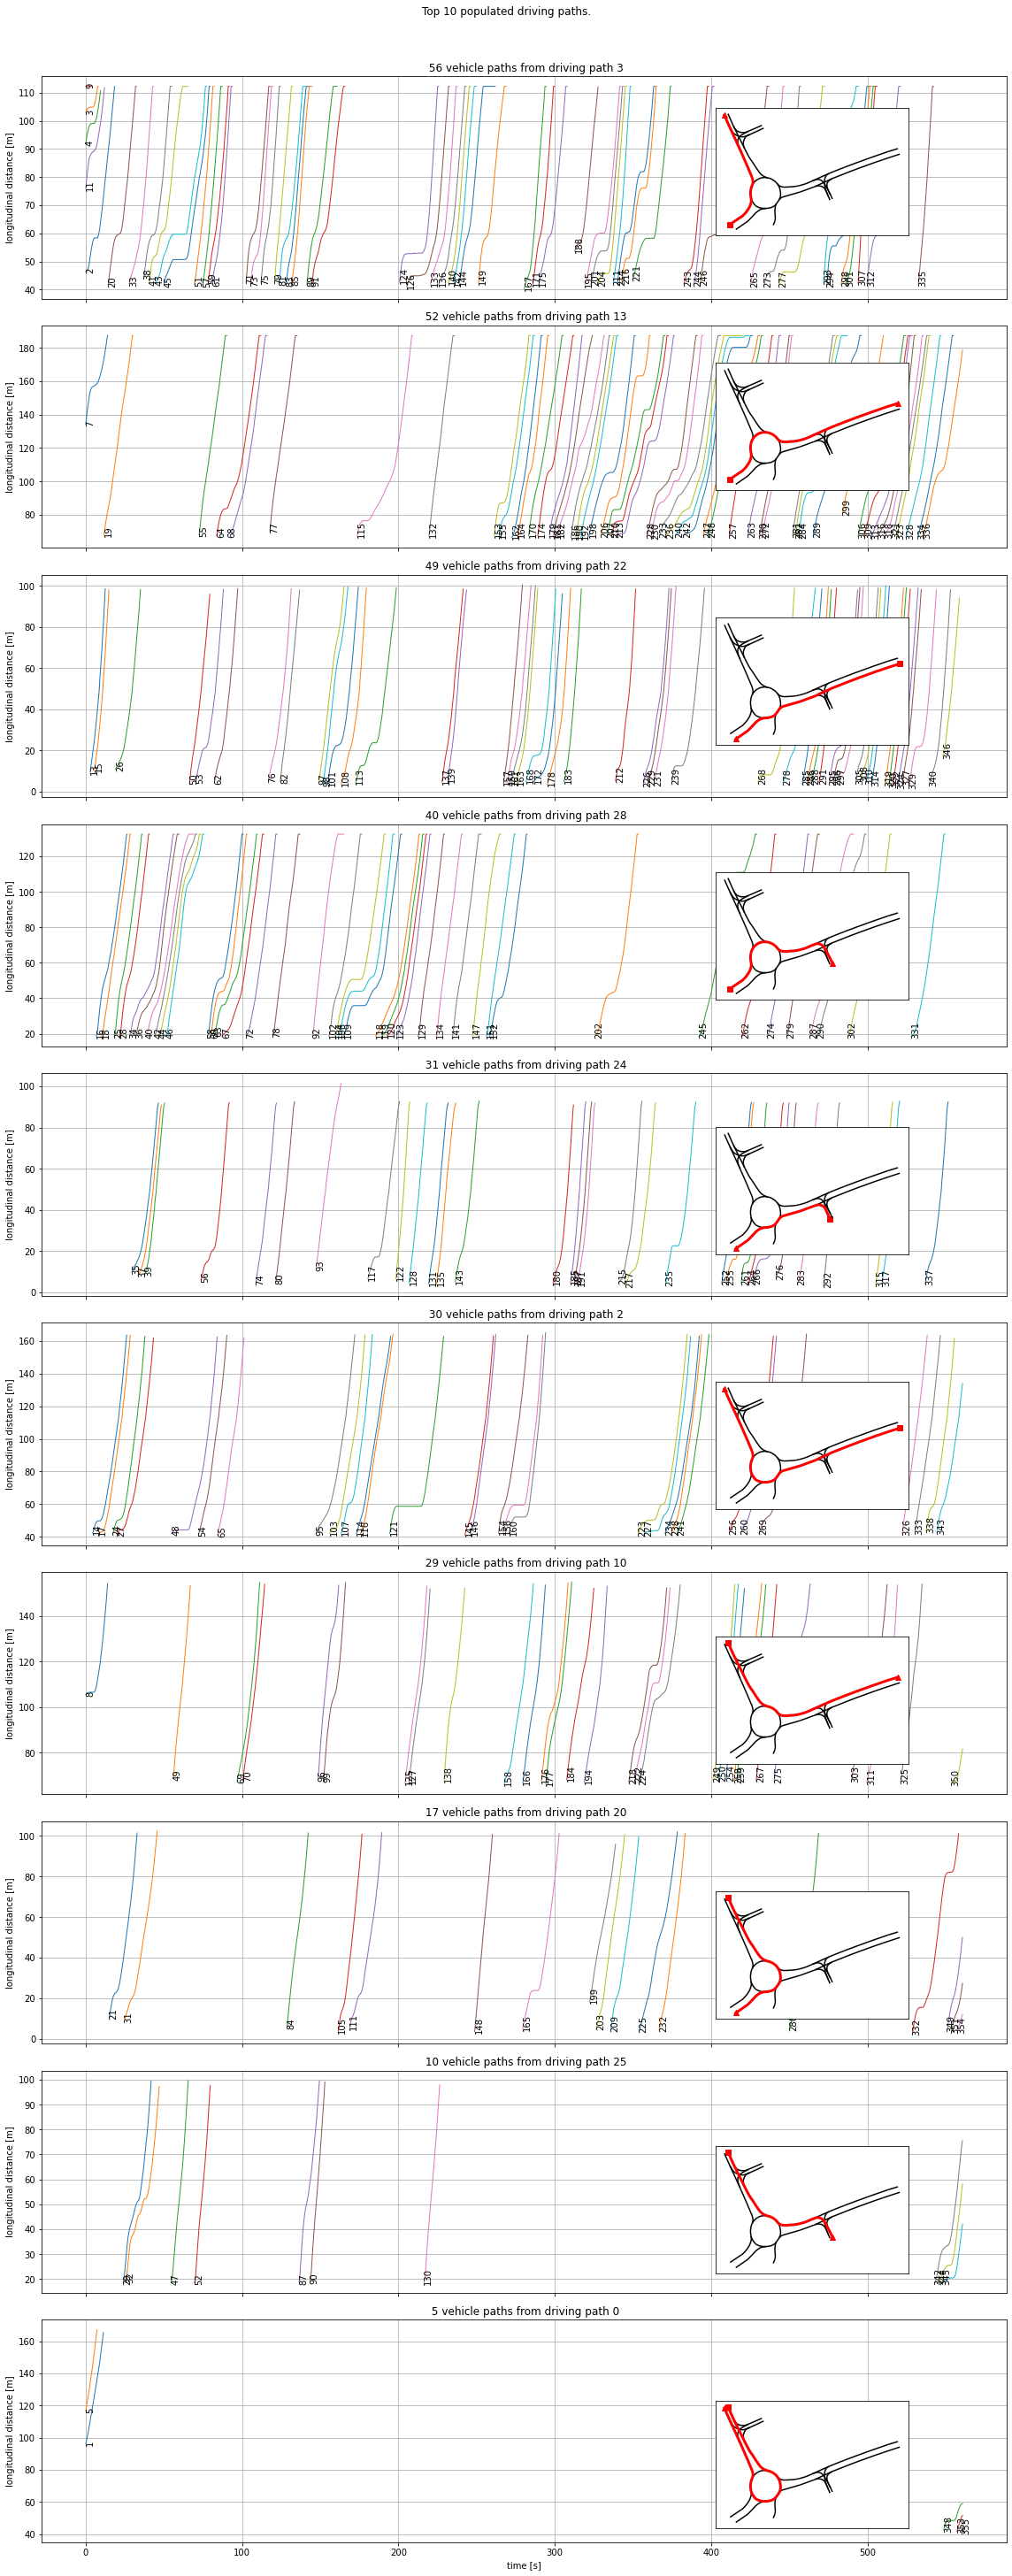

In [71]:
N = 10

fig, axs = plt.subplots(nrows=N, figsize=(16, 4*N), sharex=True)

toplist_path = gdf_traces["path_id"].value_counts()

for i, (path_id, cnt) in enumerate(toplist_path.iloc[:N].iteritems()):
    
    ax = axs[i]
    
    map_ax = fig.add_axes([0.7, 0.92 - 1/N*i, 0.2, 1/N*0.5])
    
    trafficlanes.plot(ax=map_ax, color="k", label="road network")
    paths[path_id].plot(map_ax, color="red")
    
    vehicle_paths = gdf_traces[gdf_traces["path_id"]==path_id]
    # map_ax.set_axis_off()
    map_ax.axes.get_xaxis().set_visible(False)
    map_ax.axes.get_yaxis().set_visible(False)
    
    for _, vp in vehicle_paths.iterrows():
        
        lon_array, lat_array = vp["frenet_path"].xy
        time_array = vp["START_TIME"] + 1/VEHICLE_SAMPLE_RATE*np.arange(0, vp["NUM_SAMPLES"])
        ax.plot(time_array, lon_array, lw=1)
        ax.text(time_array[0], lon_array[0], str(vp.name), fontsize=10, rotation="vertical")

    ax.set_title(f"{cnt: d} vehicle trajectories from driving path {path_id:d}")
    
    ax.grid()
    ax.set_ylabel("longitudinal distance [m]")
    
axs[-1].set_xlabel("time [s]")
    
fig.suptitle(f"Top {N} populated driving paths.", y=1.01)
plt.tight_layout()

In [72]:
print("# List of paths and corresponding objects:\n")
for path_id, row in gdf_traces.groupby("path_id").agg({"V": lambda df: list(df.index)}).iterrows():
    print(f"Path {path_id:03d}:", row["V"])

# List of paths and corresponding objects:

Path 000: [1, 5, 348, 353, 355]
Path 002: [14, 17, 24, 27, 48, 54, 65, 95, 103, 107, 114, 116, 121, 145, 146, 154, 156, 160, 223, 227, 234, 238, 241, 256, 260, 269, 326, 333, 338, 343]
Path 003: [2, 3, 4, 9, 11, 20, 33, 38, 41, 43, 45, 51, 57, 59, 61, 71, 73, 75, 79, 81, 83, 85, 89, 91, 124, 126, 133, 136, 140, 142, 144, 149, 167, 171, 175, 188, 195, 201, 204, 211, 214, 216, 221, 243, 244, 246, 265, 273, 277, 293, 294, 298, 301, 307, 312, 335]
Path 004: [110]
Path 010: [8, 49, 69, 70, 96, 99, 125, 127, 138, 158, 166, 176, 177, 184, 194, 218, 222, 224, 249, 250, 254, 258, 259, 267, 275, 303, 311, 325, 350]
Path 012: [112, 339, 341]
Path 013: [7, 19, 55, 64, 68, 77, 115, 132, 153, 155, 162, 164, 170, 174, 179, 181, 182, 186, 190, 192, 198, 206, 207, 210, 213, 228, 230, 233, 236, 240, 242, 247, 248, 257, 263, 270, 272, 281, 282, 284, 289, 299, 306, 309, 313, 316, 318, 321, 323, 328, 334, 336]
Path 014: [173, 356]
Path 015: [66, 86, 271]
Path 017

# Identify "drive offs"

In [73]:
# add position on the path
gdf_traces["S"] = gdf_traces["frenet_path"].apply(lambda row: row.xy[0])

## Single example

In [74]:
vp1 = gdf_traces.query("OBJID == 195").iloc[0]
vp2 = gdf_traces.query("OBJID == 201").iloc[0]

In [75]:
cols = ["S", "V", "ACC", "STATE"]
traj1, traj2 = Trajectory.from_trace(vp1, cols), Trajectory.from_trace(vp2, cols)

In [76]:
def identify_driveoffs(states: pd.Series) -> List[float]:
    
    state_change = np.diff(states)
    
    d = VehicleState.DRIVING.value - VehicleState.STANDING.value
    state_change_indices = np.nonzero(state_change == d)[0] + 1
    
    if len(state_change_indices) < 1:
        return []
    else:
        res_list = list()
        for i in state_change_indices:
            res_list.append(states.index[i])
        return res_list

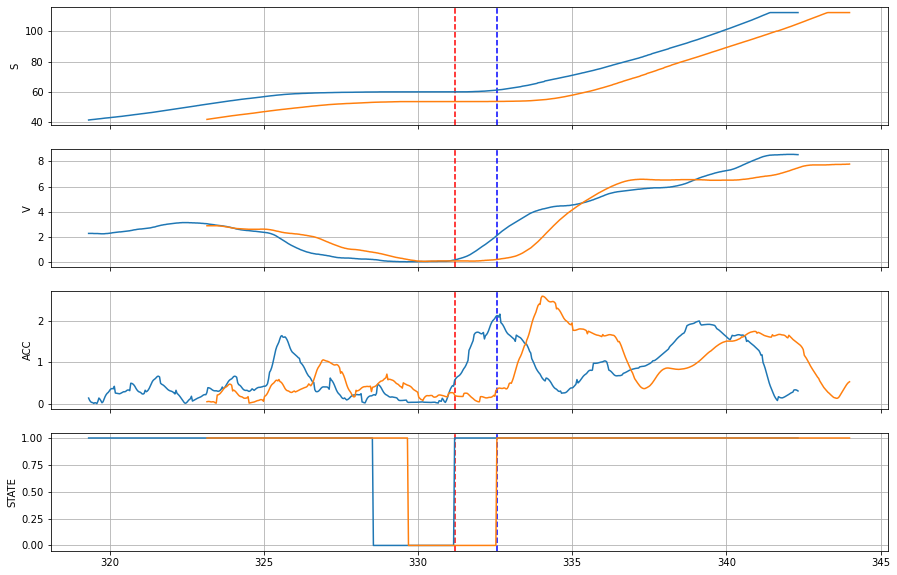

In [77]:
fig, axs = plt.subplots(nrows=traj1.dim, figsize=(15, 10), sharex=True)

for i, ax in enumerate(axs):
    ax.set_ylabel(traj1.names[i])
    ax.grid()
    
    
    for t in identify_driveoffs(traj1.get("STATE")):
        ax.axvline(t, color="r", ls="--")
        
    for t in identify_driveoffs(traj2.get("STATE")):
        ax.axvline(t, color="b", ls="--")
    
traj1.plot(axs, cols[:])
traj2.plot(axs, cols[:])



In [78]:
@dataclass
class DriveOffSituation:
    
    o1_id: int
    o2_id: int
    
    t: float
    
    distance: float
    
    o2_state: VehicleState
    o2_timedelta_drive_off: Optional[float] 
    o2_velocity: float

In [79]:
def analyze_drive_offs(traj1: Trajectory, traj2: Trajectory) -> List[DriveOffSituation]:
    
    common_time_range =  traj1.temporal_intersection(traj2) 
    if common_time_range[0] > common_time_range[1]:
        return list()
    
    o1_veh_states = traj1.get("STATE")
    o2_veh_states = traj2.get("STATE")
    
    o2_velocities = traj2.get("V")
    
    o1_drive_offs = identify_driveoffs(o1_veh_states)
    o2_drive_offs = identify_driveoffs(o2_veh_states)
    
    if len(o1_drive_offs) < 1:
        # return empty list
        return list()
    
    o2_drive_offs = np.array(o2_drive_offs)
    
    situations = list()
    
    # for each drive-off of the first object
    for t_drive_off in o1_drive_offs:
        
        o1_state = traj1.sample(t_drive_off)
        o1_position_lon = o1_state["S"]
        
        # sample state of the second
        o2_state = traj2.sample(t_drive_off)
        
        o2_driving_state = int(o2_state["STATE"])
        
        o2_position_lon = o2_state["S"]
        o2_velocity = o2_state["V"]
        
        distance = o1_position_lon - o2_position_lon 
        
        if o2_driving_state == VehicleState.STANDING:
            time_drive_off_after_first = o2_drive_offs[o2_drive_offs >= t_drive_off][0]
            
            time_delta = time_drive_off_after_first - t_drive_off
            
            situation = DriveOffSituation(traj1.name, traj2.name, t_drive_off, distance, 
                                            VehicleState.STANDING, time_delta, o2_velocity)
            
            situations.append(situation)
        
        elif o2_driving_state == VehicleState.DRIVING:
            
            o2_velocities
            situation = DriveOffSituation(traj1.name, traj2.name, t_drive_off, distance, 
                                            VehicleState.DRIVING, None, o2_velocity)
            situations.append(situation)
        else:
            raise ValueError("Interesting ...")
    return situations

In [80]:
drive_off_situations = analyze_drive_offs(traj1, traj2)

In [81]:
pd.DataFrame(drive_off_situations)

,o1_id,o2_id,t,distance,o2_state,o2_timedelta_drive_off,o2_velocity
0,195,201,331.185667,6.35,0,1.3705,0.08


## All drive-offs from a path

In [82]:
from itertools import tee

In [83]:
def pairwise(iterable):
    # pairwise('ABCDEFG') --> AB BC CD DE EF FG
    a, b = tee(iterable)
    next(b, None)
    return zip(a, b)

In [84]:
def analyze_driveoffs_from_path(path_trajectories: gpd.GeoDataFrame) -> pd.DataFrame:
    # Assumptions: NO OVERTAKES!
    
    # identify the starting (long.) location of each trajectory for sorting
    # would fail in the first second, if not done
    path_trajectories["START_LON"] = path_trajectories["frenet_path"].apply(lambda ls: ls.xy[0][0])
    
    path_trajectories = path_trajectories.sort_values(["START_TIME", "START_LON"], ascending=[True, False])
    
    situations = list()
    for i, (o1, o2) in enumerate(pairwise(range(len(path_trajectories)))):
        o1_row = path_trajectories.iloc[o1]
        o2_row = path_trajectories.iloc[o2]
        
        cols = ["S", "V", "ACC", "STATE"]
        traj1, traj2 = Trajectory.from_trace(o1_row, cols), Trajectory.from_trace(o2_row, cols)
        
        drive_off_situations = analyze_drive_offs(traj1, traj2)
        situations += drive_off_situations
        
    df_situations = pd.DataFrame(situations)
        
    return df_situations

In [85]:
df_situations = gdf_traces.groupby("path_id").apply(analyze_driveoffs_from_path)
df_situations["o1_id"] = df_situations["o1_id"].astype(int)
df_situations["o2_id"] = df_situations["o2_id"].astype(int)
df_situations["o2_state"] = df_situations["o2_state"].astype(int)

In [86]:
df_situations.sort_values("o2_timedelta_drive_off").head(10)

o1_id  o2_id           t  distance  o2_state  \
path_id                                                    
3       1       3      4    4.233333      5.75         0   
        7     124    126  215.033833      7.85         0   
28      0     104    106  175.659334      6.60         0   
24      3     264    266  434.257000      5.90         0   
13      8     228    230  377.358500      6.75         0   
2       3     156    160  279.800000      7.25         0   
10      0     218    222  364.413667      7.75         0   
13      5     210    213  342.502667      7.45         0   
3       13    214    216  356.473000      5.85         0   
        11    201    204  332.556167      8.10         0   

            o2_timedelta_drive_off  o2_velocity  
path_id                                          
3       1                 0.100000         0.14  
        7                 0.338000         0.15  
28      0                 0.602000         0.07  
24      3                 0.702500         0.05  
13      8                 0.902666         0.09  
2       3                 0.970500         0.00  
10      0                 0.970500         0.09  
13      5                 1.069667         0.10  
3       13                1.136167         0.02  
        11                1.270999         0.01

In [87]:
df_situations[df_situations["o2_state"] == VehicleState.STANDING]["o2_timedelta_drive_off"].describe()

count    17.000000
mean      1.215127
std       0.600938
min       0.100000
25%       0.902666
50%       1.136167
75%       1.636000
max       2.172499
Name: o2_timedelta_drive_off, dtype: float64

In [88]:
df_situations[df_situations["o2_state"] == VehicleState.STANDING]["distance"].describe()

count    17.000000
mean      6.558824
std       1.683860
min       1.000000
25%       5.900000
50%       6.750000
75%       7.750000
max       8.150000
Name: distance, dtype: float64

In [89]:
(df_situations[df_situations["distance"] < 20]["o2_velocity"]*3.6).describe()

count    63.000000
mean      6.810857
std       7.892482
min       0.000000
25%       0.558000
50%       2.412000
75%      12.330000
max      30.456000
Name: o2_velocity, dtype: float64

In [90]:
(df_situations["o2_state"] == VehicleState.STANDING).mean()

0.22972972972972974

In [91]:
len(df_situations)

74

In [92]:
gdf_traces["LENGTH"].describe()

count    332.000000
mean       4.559069
std        0.816798
min        2.166900
25%        4.287125
50%        4.454200
75%        4.759250
max       10.660800
Name: LENGTH, dtype: float64

In [93]:
gdf_traces.head()

,CLASS,WIDTH,LENGTH,START_TIME,NUM_SAMPLES,V,ACC,geometry,START_TIME_DISCRETE,STATE,path_id,frenet_path,S
OBJID,,,,,,,,,,,,,
1,Heavy Vehicle,2.7892,6.0217,0.0,341,"[4.74, 4.75, 4.75, 4.75, 4.76, 4.76, 4.77, 4.7...","[0.1415, 0.1341, 0.1316, 0.1368, 0.1568, 0.254...","LINESTRING (619302.330 5809133.780, 619302.470...",0,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0,"LINESTRING (96.30000 2.09837, 96.40000 2.00893...","[96.30000000000008, 96.40000000000009, 96.5500..."
2,Car,1.7950,4.3806,0.0,556,"[0.33, 0.34, 0.34, 0.35, 0.36, 0.37, 0.39, 0.4...","[0.1092, 0.1466, 0.1976, 0.285, 0.4123, 0.5232...","LINESTRING (619286.670 5809178.010, 619286.680...",0,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",3,"LINESTRING (46.40000 0.03046, 46.40000 0.02531...","[46.40000000000004, 46.40000000000004, 46.4000..."
3,Car,1.8667,3.7854,0.0,241,"[1.32, 1.32, 1.32, 1.32, 1.32, 1.31, 1.31, 1.3...","[0.0693, 0.0556, 0.0376, 0.0246, 0.0954, 0.177...","LINESTRING (619281.510 5809126.720, 619281.470...",0,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",3,"LINESTRING (103.00000 0.45052, 103.05000 0.453...","[103.00000000000009, 103.0500000000001, 103.10..."
4,Car,1.7642,4.4819,0.0,286,"[3.78, 3.75, 3.72, 3.68, 3.64, 3.6, 3.56, 3.52...","[0.9199, 1.0231, 1.1121, 1.1865, 1.2474, 1.308...","LINESTRING (619288.840 5809134.990, 619288.780...",0,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",3,"LINESTRING (91.90000 0.25943, 92.05000 0.24765...","[91.90000000000008, 92.05000000000008, 92.1500..."
5,Medium Vehicle,2.1041,4.8186,0.0,216,"[4.6, 4.63, 4.66, 4.69, 4.72, 4.75, 4.78, 4.82...","[1.3951, 1.5709, 1.7314, 1.8746, 2.0001, 2.119...","LINESTRING (619316.990 5809146.380, 619317.010...",0,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0,"LINESTRING (116.60000 1.25671, 116.75000 1.285...","[116.60000000000011, 116.7500000000001, 116.90..."


In [94]:
def visualize_object_traces(objects: List[int]) -> mpl.figure.Figure:
    
    traces = [gdf_traces.query(f"OBJID == {obj:d}").iloc[0] for obj in objects]
    
    cols = ["S", "V", "ACC", "STATE"]
    trajs = [Trajectory.from_trace(trace, cols) for trace in traces]
    
    fig, axs = plt.subplots(nrows=trajs[0].dim, figsize=(15, 10), sharex=True)
    
    for traj in trajs:
        traj.plot(axs, cols[:]) 

    for i, ax in enumerate(axs):
        ax.set_ylabel(trajs[0].names[i])
        ax.grid()
        
    axs[-1].set_yticks([VehicleState.STANDING.value, VehicleState.DRIVING.value])
    axs[-1].set_yticklabels([VehicleState.STANDING.name, VehicleState.DRIVING.name])
        
    return fig

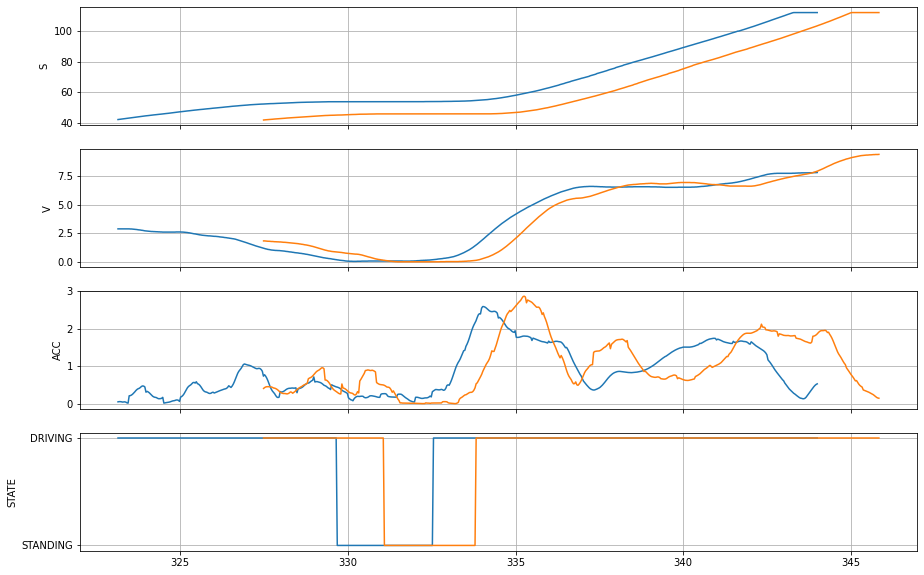

In [95]:
visualize_object_traces([201, 204]);